# GTZAN_4_ens_RandomForestClassifier
---

In [1]:
import numpy as np
import pandas as pd
import librosa
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Read in file

In [2]:
# read in file
filepath = '../gtzan/own_csv/df_noduplicates.csv'
df_3 = pd.read_csv(filepath, index_col=0)

# drop columns: 'filename', 'length' 
df_3.drop(columns=['filename', 'length'], inplace=True)

print(df_3.shape)
df_3.head(3)

(9847, 58)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


# Set target, predictors, standardization

In [3]:
# set target and features
X = df_3.copy()
y = X.pop('label')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# standardscaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Baseline
y_test.value_counts(normalize=True)

blues        0.101523
classical    0.101523
jazz         0.101523
country      0.101015
disco        0.100508
rock         0.100508
reggae       0.100000
hiphop       0.099492
pop          0.099492
metal        0.094416
Name: label, dtype: float64

# PCA (all features)

In [4]:
# PCA (n_components: 0.9999)
n_components = 0.9999
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print(pca.explained_variance_ratio_.cumsum())

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_47,PC_48,PC_49,PC_50,PC_51,PC_52,PC_53,PC_54,PC_55,PC_56
6535,-5.273166,-6.167187,1.345471,1.123555,-0.603370,0.771625,0.755719,-1.004752,-0.159771,-0.063493,...,0.121074,-0.019945,0.445561,0.271364,-0.479309,-0.523248,0.187016,0.103133,-0.100394,0.014560
625,-0.515342,1.813487,4.630386,1.915605,1.681363,0.436591,-2.147151,-0.577363,-0.365986,-0.371310,...,0.064622,0.632422,0.140321,0.062738,0.381988,0.037552,-0.210541,-0.120403,-0.048747,-0.000290
1949,-1.794878,2.274721,3.316637,3.989158,-2.708549,1.932897,3.609233,2.383106,-3.494039,4.396239,...,0.203891,0.191172,-0.026600,0.886325,0.137341,-0.311034,0.018842,-0.080876,-0.192847,-0.346759


[0.19693593 0.33277709 0.43657312 0.50294066 0.54678617 0.58377001
 0.61335998 0.64023907 0.6654956  0.68693547 0.70569705 0.72351818
 0.74058495 0.75561978 0.76921124 0.78091766 0.79207139 0.8028624
 0.81266499 0.82197806 0.8307666  0.8393097  0.84764316 0.85579663
 0.86365234 0.8712389  0.8787581  0.88603821 0.89305122 0.89996235
 0.90665321 0.91317655 0.91945846 0.92558516 0.93161825 0.93740046
 0.94281321 0.94806709 0.95306707 0.95768618 0.96227398 0.96674103
 0.97104055 0.97518641 0.97913969 0.98283504 0.9863513  0.98951242
 0.99244916 0.99497769 0.99679816 0.99807571 0.99902133 0.99959884
 0.99980932 0.99994241]


# RFC (original features)

In [8]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

# scores
print('cv mean:\t', cross_val_score(rfc, X_train, y_train, cv=5).mean())
print('train score:\t', rfc.score(X_train, y_train))
print('test score:\t', rfc.score(X_test, y_test))

cv mean:	 0.85273539601966
train score:	 1.0
test score:	 0.8583756345177666


# Gridsearch RFC (original features)

In [13]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators':[50,100,200, 500],
    'criterion':['gini', 'entropy'],
    'max_depth':[10,20,50, None],
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     bootstrap=True,
#     oob_score=False,
    'n_jobs':[2],
    'random_state':[1],
    'verbose':[1],
#     warm_start=False,
    'class_weight':['balanced'],
#     ccp_alpha=0.0,
#     max_samples=None,
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=2, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed: 10.3min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:   12.0s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=2,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 50, None],
                         'n_estimators': [50, 100, 200, 500], 'n_jobs': [2],
                         'random_state': [1], 'verbose': [1]},
             verbose=1)

In [14]:
print('grid best estimator:\t', grid.best_estimator_)
print('grid best params:\t', grid.best_params_)
print()
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train, y_train))
print('grid test score:\t', grid.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s


grid best estimator:	 RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=500,
                       n_jobs=2, random_state=1, verbose=1)
grid best params:	 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'n_estimators': 500, 'n_jobs': 2, 'random_state': 1, 'verbose': 1}

grid cv mean:		 0.864542019176537


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s


grid train score:	 1.0
grid test score:	 0.8639593908629442


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.2s finished


In [15]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators':[200, 300, 500, 1000],
    'criterion':['gini', 'entropy'],
    'max_depth':[10,15,20,25,30,50],
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     bootstrap=True,
#     oob_score=False,
    'n_jobs':[2],
    'random_state':[1],
    'verbose':[1],
#     warm_start=False,
    'class_weight':['balanced'],
#     ccp_alpha=0.0,
#     max_samples=None,
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-2, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-2)]: Done 240 out of 240 | elapsed: 22.0min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:   18.3s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:   23.1s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, 30, 50],
                         'n_estimators': [200, 300, 500, 1000], 'n_jobs': [2],
                         'random_state': [1], 'verbose': [1]},
             verbose=1)

In [16]:
print('grid best estimator:\t', grid.best_estimator_)
print('grid best params:\t', grid.best_params_)
print()
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train, y_train))
print('grid test score:\t', grid.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s


grid best estimator:	 RandomForestClassifier(class_weight='balanced', max_depth=25, n_estimators=1000,
                       n_jobs=2, random_state=1, verbose=1)
grid best params:	 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 25, 'n_estimators': 1000, 'n_jobs': 2, 'random_state': 1, 'verbose': 1}

grid cv mean:		 0.8664458947707679


[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s


grid train score:	 1.0


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.2s


grid test score:	 0.8736040609137056


[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.3s finished


In [19]:
rfc = RandomForestClassifier()

param_grid = {
    'n_estimators':[500, 1000, 1500],
    'criterion':['gini', 'entropy'],
    'max_depth':[i for i in range(21,31)],
#     min_samples_split=2,
#     min_samples_leaf=1,
#     min_weight_fraction_leaf=0.0,
#     max_features='auto',
#     max_leaf_nodes=None,
#     min_impurity_decrease=0.0,
#     min_impurity_split=None,
#     bootstrap=True,
#     oob_score=False,
    'n_jobs':[-2],
    'random_state':[1],
    'verbose':[1],
#     warm_start=False,
    'class_weight':['balanced'],
#     ccp_alpha=0.0,
#     max_samples=None,
}

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-2, cv=5, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-2)]: Done 300 out of 300 | elapsed: 51.4min finished
[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-2)]: Done 436 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-2)]: Done 786 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-2)]: Done 1236 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-2)]: Done 1500 out of 1500 | elapsed:   16.8s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-2,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                         'n_estimators': [500, 1000, 1500], 'n_jobs': [-2],
                         'random_state': [1], 'verbose': [1]},
             verbose=1)

In [20]:
print('grid best estimator:\t', grid.best_estimator_)
print('grid best params:\t', grid.best_params_)
print()
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train, y_train))
print('grid test score:\t', grid.score(X_test, y_test))

[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s


grid best estimator:	 RandomForestClassifier(class_weight='balanced', max_depth=29, n_estimators=1500,
                       n_jobs=-2, random_state=1, verbose=1)
grid best params:	 {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'n_estimators': 1500, 'n_jobs': -2, 'random_state': 1, 'verbose': 1}

grid cv mean:		 0.8665732817661752


[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s


grid train score:	 1.0


[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.3s


grid test score:	 0.8746192893401015


[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.5s finished


In [21]:
grid.param_grid

{'n_estimators': [500, 1000, 1500],
 'criterion': ['gini', 'entropy'],
 'max_depth': [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
 'n_jobs': [-2],
 'random_state': [1],
 'verbose': [1],
 'class_weight': ['balanced']}

In [22]:
print('grid cv mean:\t\t', grid.best_score_)
print('grid train score:\t', grid.score(X_train, y_train))
print('grid test score:\t', grid.score(X_test, y_test))

grid cv mean:		 0.8665732817661752


[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.7s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.8s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s


grid train score:	 1.0


[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.2s


grid test score:	 0.8746192893401015


[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.5s finished


# Save / Load Model (pickle)

In [24]:
# pickle model
filename = 'grid_rfc.pkl'
pickle.dump(grid, open(filename, 'wb'))

In [5]:
# read in model
filename = 'grid_rfc.pkl'
grid_rfc = pickle.load(open(filename, 'rb'))

Grid RFC optimal max_depth: 29



[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.6s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.7s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s


train score:	 1.0
cv mean:	 0.8665732817661752


[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.4s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s


test score:	 0.8746192893401015


[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.4s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.5s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.6s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:    0.3s
[Parallel(n_jobs=7)]: Done 1500 out of 1500 | elapsed:    0.3s finished
[Parallel(n_jobs=7)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    0.0s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: D

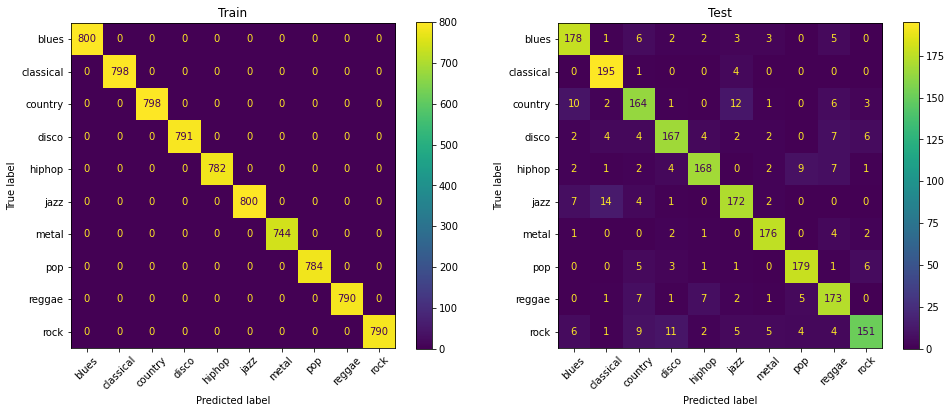

In [6]:
print(f'Grid RFC optimal max_depth: {grid_rfc.best_params_["max_depth"]}')
print()
print('train score:\t', grid_rfc.score(X_train, y_train))
print('cv mean:\t', grid_rfc.best_score_)
print('test score:\t', grid_rfc.score(X_test, y_test))

# confusion matrix
pred_train = grid_rfc.predict(X_train)
pred_test = grid_rfc.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
#display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(grid_rfc, X_train, y_train, ax=ax[0], xticks_rotation=45)
plot_confusion_matrix(grid_rfc, X_test, y_test, ax=ax[1], xticks_rotation=45)
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [7]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     1.0000    1.0000    1.0000       800
   classical     1.0000    1.0000    1.0000       798
     country     1.0000    1.0000    1.0000       798
       disco     1.0000    1.0000    1.0000       791
      hiphop     1.0000    1.0000    1.0000       782
        jazz     1.0000    1.0000    1.0000       800
       metal     1.0000    1.0000    1.0000       744
         pop     1.0000    1.0000    1.0000       784
      reggae     1.0000    1.0000    1.0000       790
        rock     1.0000    1.0000    1.0000       790

    accuracy                         1.0000      7877
   macro avg     1.0000    1.0000    1.0000      7877
weighted avg     1.0000    1.0000    1.0000      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.8641    0.8900    0.8768       200
   classical     0.8904    0.9750    0.9308       200
     coun

In [10]:
grid_rfc.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 29,
 'n_estimators': 1500,
 'n_jobs': -2,
 'random_state': 1,
 'verbose': 1}

In [12]:
rfc = RandomForestClassifier(n_estimators=grid_rfc.best_params_['n_estimators'], 
                            class_weight=grid_rfc.best_params_['class_weight'], 
                            criterion=grid_rfc.best_params_['criterion'], 
                            max_depth=grid_rfc.best_params_['max_depth'], 
                            random_state=1, n_jobs=-2)

rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=29, n_estimators=1500,
                       n_jobs=-2, random_state=1)

In [15]:
print('RFC')
print(grid_rfc.best_params_)
print()
print('train score:\t', rfc.score(X_train, y_train))
print('CV mean:\t', cross_val_score(rfc, X_train, y_train, cv=5).mean())
print('test score:\t', rfc.score(X_test, y_test))

RFC
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 29, 'n_estimators': 1500, 'n_jobs': -2, 'random_state': 1, 'verbose': 1}

train score:	 1.0
CV mean:	 0.8665732817661752
test score:	 0.8746192893401015


In [21]:
rfc.feature_importances_

array([0.03635944, 0.01882324, 0.03308162, 0.03563615, 0.02121104,
       0.02285216, 0.03141068, 0.01339263, 0.0237604 , 0.02320414,
       0.01833412, 0.01073962, 0.02070286, 0.02688309, 0.02687699,
       0.05176578, 0.01077019, 0.02694673, 0.02426115, 0.01700038,
       0.01042118, 0.01959327, 0.01762399, 0.03305962, 0.01645077,
       0.01445294, 0.01896086, 0.02182705, 0.01620622, 0.0174123 ,
       0.01453477, 0.01920238, 0.0119743 , 0.02223961, 0.01049101,
       0.01253455, 0.0114254 , 0.01645046, 0.00896959, 0.01686726,
       0.00840159, 0.01514607, 0.00884421, 0.01179724, 0.00782215,
       0.01313051, 0.00766274, 0.01064507, 0.00781285, 0.01379743,
       0.00813892, 0.01047265, 0.00897492, 0.0099946 , 0.01068014,
       0.01098077, 0.01098817])

In [30]:
df_featimp = pd.DataFrame(data=[X_train.columns, rfc.feature_importances_]).T
df_featimp.columns = ['feature', 'feature_importance']

df_featimp.sort_values(by='feature_importance', ascending=False)

,feature,feature_importance
15,perceptr_var,0.0517658
0,chroma_stft_mean,0.0363594
3,rms_var,0.0356362
2,rms_mean,0.0330816
23,mfcc4_mean,0.0330596
6,spectral_bandwidth_mean,0.0314107
17,mfcc1_mean,0.0269467
13,harmony_var,0.0268831
14,perceptr_mean,0.026877
18,mfcc1_var,0.0242612


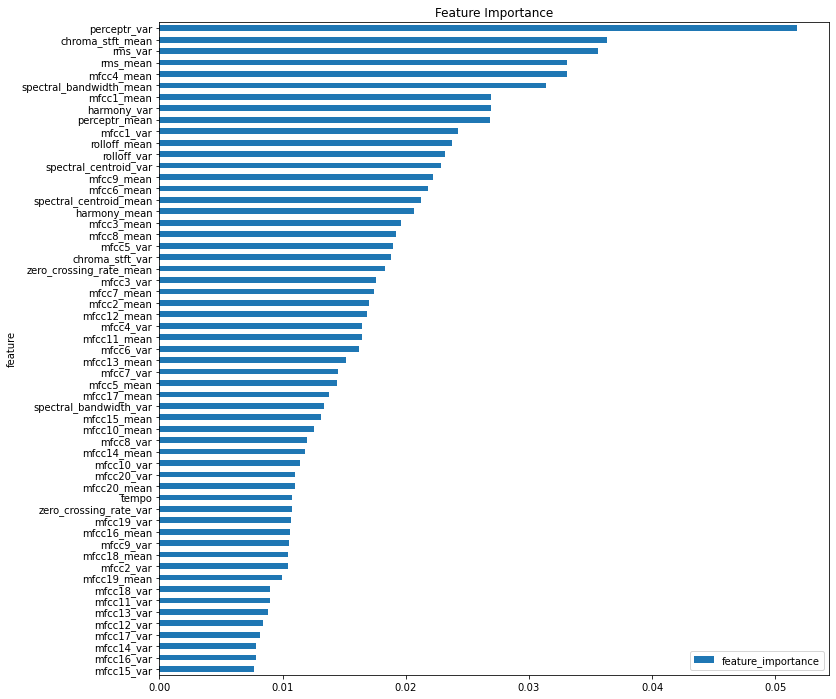

In [46]:
fig, ax = plt.subplots(1,1, figsize=(12,12))
df_featimp.sort_values(by='feature_importance', ascending=True).plot(kind='barh', x='feature', ax=ax)
plt.title('Feature Importance')
plt.show()

# Precision - Recall

In [48]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

In [49]:
def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [50]:
proba_train = rfc.predict_proba(X_train)
proba_test = rfc.predict_proba(X_test)

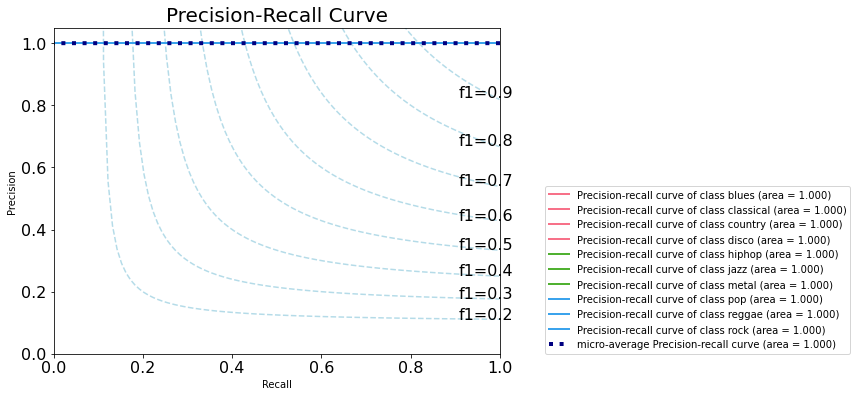

In [51]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_train, proba_train, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

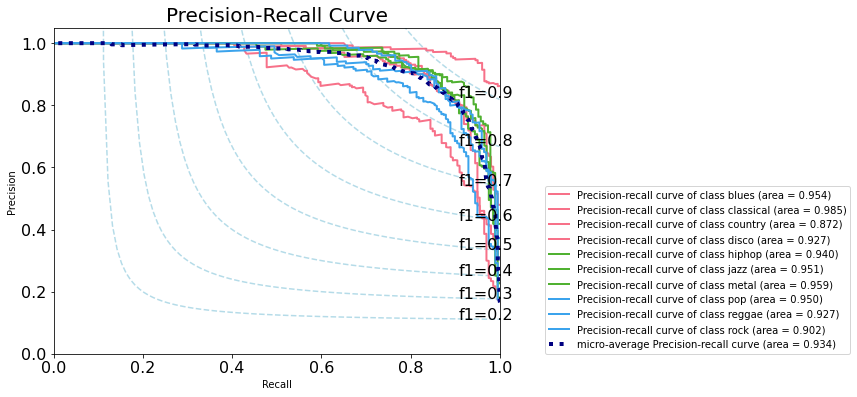

In [52]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, proba_test, 
                       plot_micro=True, 
                       title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1,0])
plt.show()

# ROC

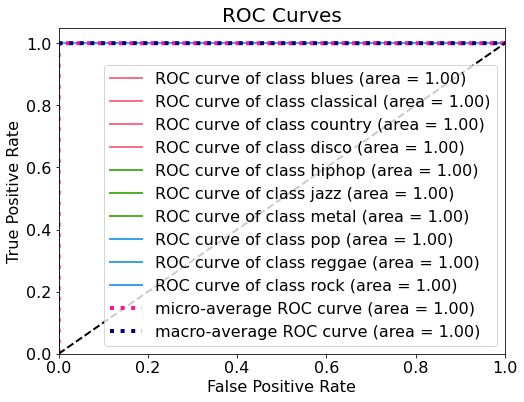

In [53]:
# ROC train
skplt.metrics.plot_roc(y_train, proba_train, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()

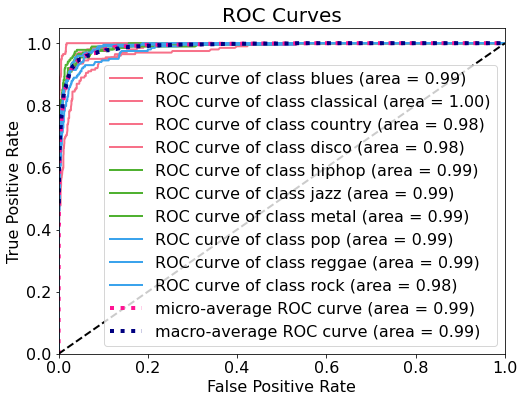

In [54]:
# ROC test
skplt.metrics.plot_roc(y_test, proba_test, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=16, figsize=(8,6), cmap=cmap)
plt.show()